In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Model, regularizers
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, SGD
from sklearn.metrics import confusion_matrix,classification_report
from keras.models import Sequential


In [14]:
train_dir = 'dataset/train'
test_dir = 'dataset/test'
val_dir= 'dataset/val'

In [15]:
Image_size = 224
input_shape = (224,224,3)

def scalar(img):
    return img


tr_gen = ImageDataGenerator(preprocessing_function=scalar,
                            horizontal_flip=True,
                            vertical_flip=True)


train_gen = tr_gen.flow_from_directory(
              directory = os.path.join(train_dir),
              target_size=(Image_size,Image_size),
              batch_size =32,shuffle=True,
             class_mode='categorical')

test_gen = ImageDataGenerator(preprocessing_function=scalar).flow_from_directory(
              directory = os.path.join(test_dir),
              target_size=(Image_size,Image_size),
              batch_size =32,shuffle=True,
             class_mode='categorical')

val_gen = ImageDataGenerator(preprocessing_function=scalar).flow_from_directory(
              directory = os.path.join(val_dir),
              target_size=(Image_size,Image_size),
              batch_size =32,shuffle=True,
             class_mode='categorical')

Found 154 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Found 44 images belonging to 3 classes.


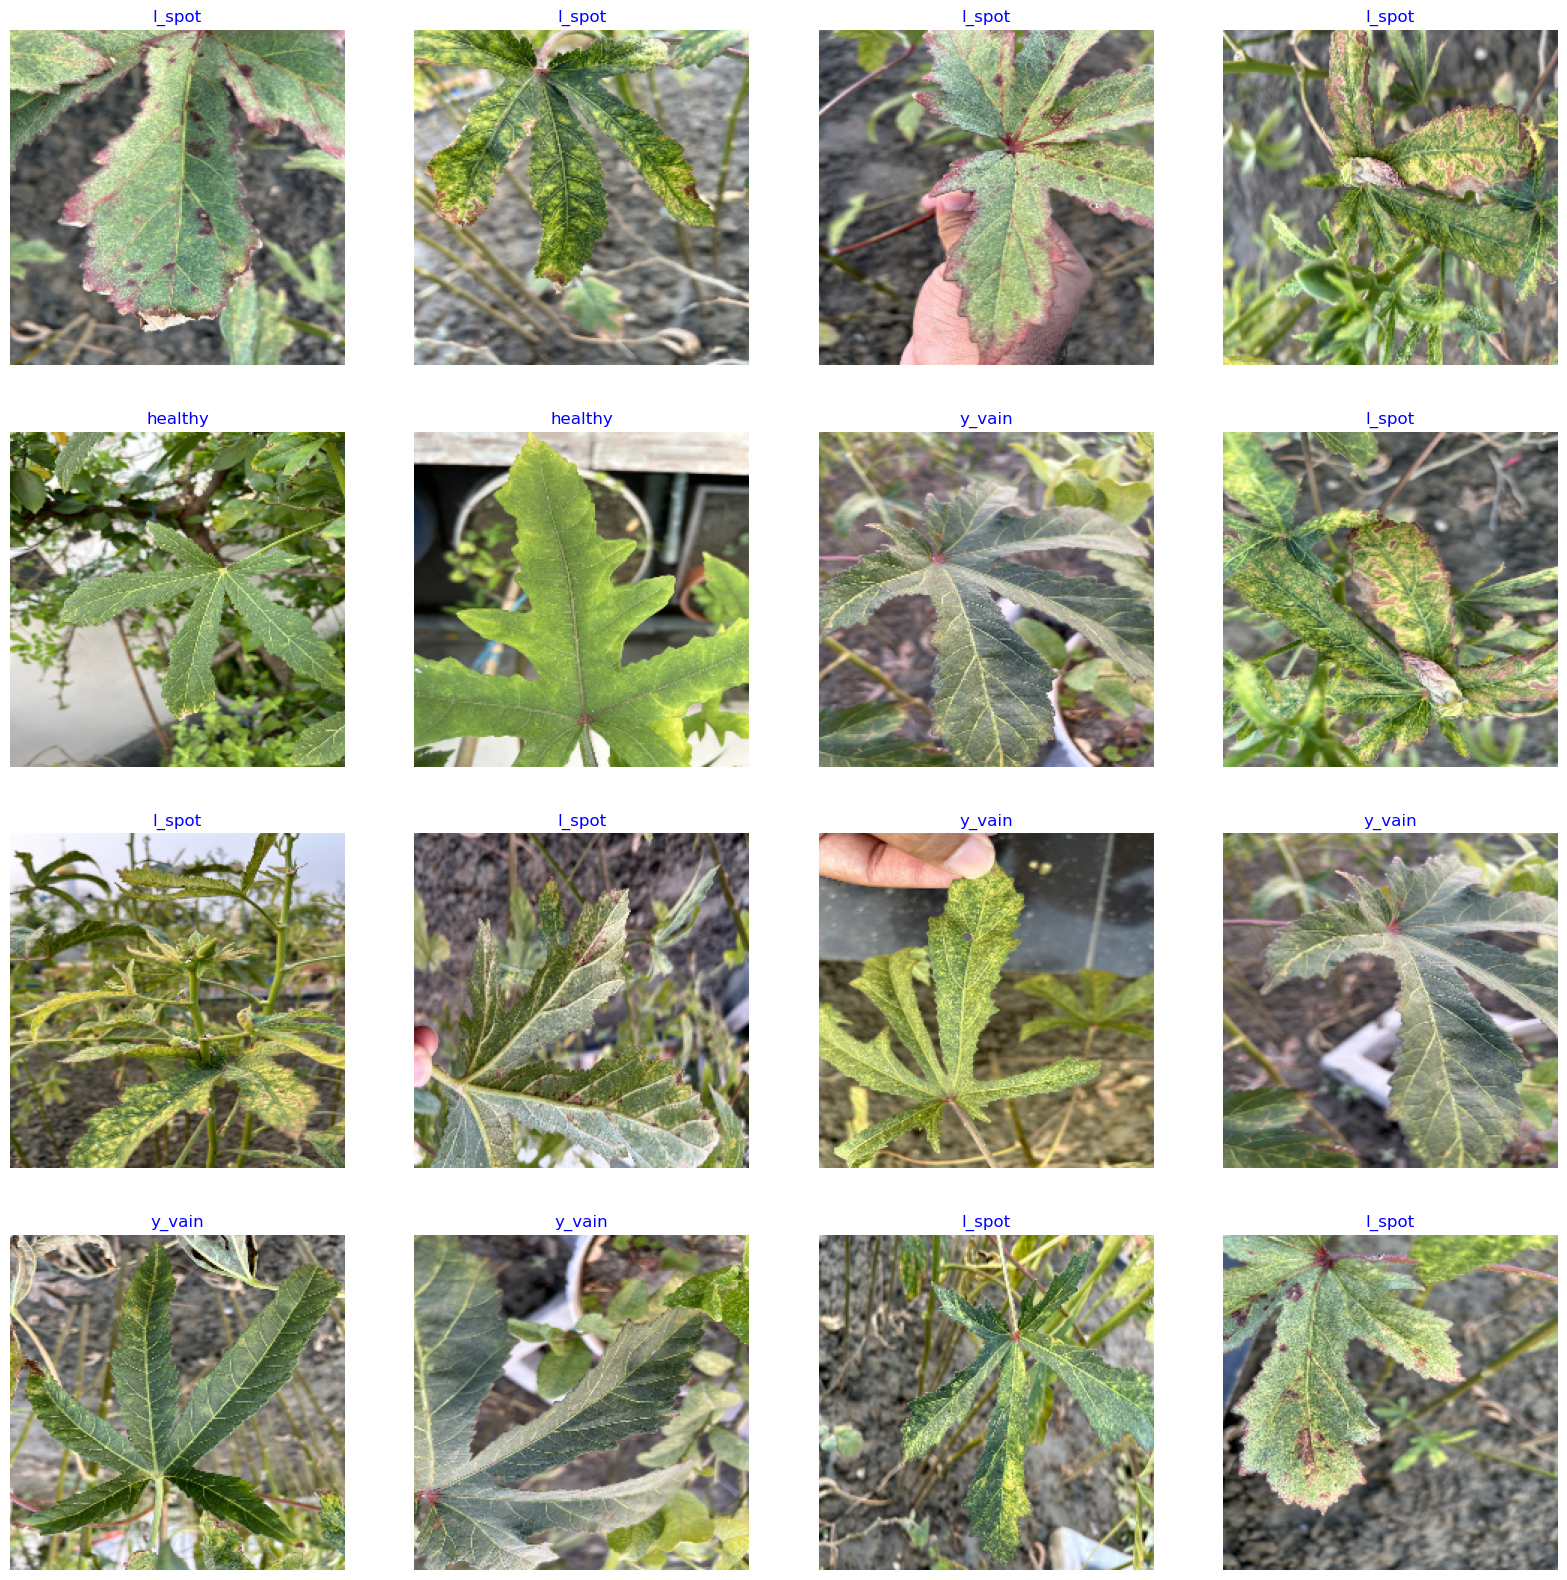

In [16]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]   /255   # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

In [17]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.DenseNet121(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

for layer in base_model.layers:
    layer.trainable= False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 7,304,771
Trainable params: 265,219
Non-trainable params: 7,039,552
______________________________________

In [18]:
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=50,
                    verbose=True)

Epoch 1/50
5/5 [==============================] - 49s 8s/step - loss: 8.3755 - accuracy: 0.4740 - val_loss: 29.3638 - val_accuracy: 0.2727
Epoch 2/50
5/5 [==============================] - 30s 6s/step - loss: 7.6066 - accuracy: 0.6558 - val_loss: 20.1508 - val_accuracy: 0.2727
Epoch 3/50
5/5 [==============================] - 30s 6s/step - loss: 7.0837 - accuracy: 0.7273 - val_loss: 14.4689 - val_accuracy: 0.2727
Epoch 4/50
5/5 [==============================] - 30s 6s/step - loss: 6.7095 - accuracy: 0.7987 - val_loss: 11.4819 - val_accuracy: 0.2727
Epoch 5/50
5/5 [==============================] - 30s 6s/step - loss: 6.4433 - accuracy: 0.8182 - val_loss: 9.5653 - val_accuracy: 0.3864
Epoch 6/50
5/5 [==============================] - 30s 6s/step - loss: 6.1661 - accuracy: 0.8377 - val_loss: 8.5669 - val_accuracy: 0.4545
Epoch 7/50
5/5 [==============================] - 30s 6s/step - loss: 5.9403 - accuracy: 0.8636 - val_loss: 8.0904 - val_accuracy: 0.4773
Epoch 8/50
5/5 [==============

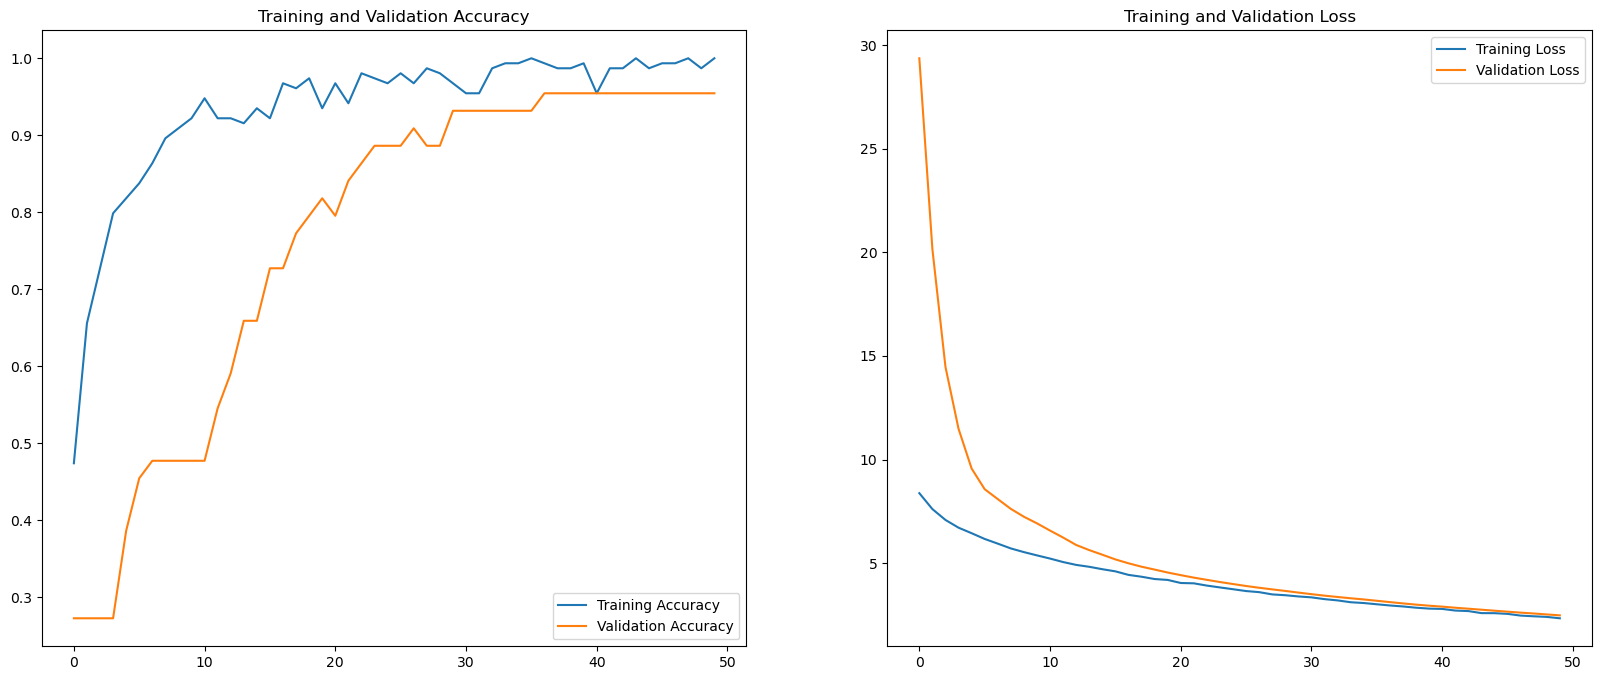

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
model.evaluate(test_gen)

1/1 [==============================] - 4s 4s/step - loss: 2.4560 - accuracy: 0.9583


[2.4559783935546875, 0.9583333134651184]

In [21]:
predictions =model.predict(test_gen)

1/1 [==============================] - 7s 7s/step


In [22]:
predictions[:5]

array([[0.06471696, 0.8823355 , 0.05294755],
       [0.02584619, 0.06844818, 0.90570575],
       [0.19130826, 0.06477895, 0.7439128 ],
       [0.01097519, 0.9370642 , 0.05196058],
       [0.9860692 , 0.0117985 , 0.00213218]], dtype=float32)

In [23]:
y_test = []
y_test_int = []
for i in tqdm(range(len(test_gen))):
    y_test += test_gen[i][1].tolist()
    y_test_int += test_gen[i][1].argmax(axis=1).tolist()
y_test = np.array(y_test)
y_test_int = np.array(y_test_int)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.52s/it]


In [24]:
y_pred_test = model.predict(test_gen, verbose=1)
y_pred_test_int = y_pred_test.argmax(axis=1)
print(y_pred_test,y_pred_test_int)

1/1 [==============================] - 4s 4s/step
[[0.06318703 0.85245436 0.08435857]
 [0.12817785 0.06061658 0.8112056 ]
 [0.06471696 0.8823355  0.05294755]
 [0.01097519 0.9370642  0.05196058]
 [0.06268917 0.89206266 0.04524813]
 [0.9860692  0.0117985  0.00213218]
 [0.96734434 0.00907314 0.02358258]
 [0.08904549 0.7353819  0.17557253]
 [0.03294721 0.78544104 0.18161178]
 [0.07572493 0.04505147 0.8792235 ]
 [0.19130826 0.06477895 0.7439128 ]
 [0.988859   0.00621797 0.0049229 ]
 [0.19721133 0.55340606 0.24938266]
 [0.9730306  0.00729007 0.01967922]
 [0.02584619 0.06844818 0.90570575]
 [0.05364321 0.8276671  0.11868967]
 [0.04555978 0.36381873 0.5906214 ]
 [0.02977978 0.168483   0.8017372 ]
 [0.18130744 0.36603224 0.4526603 ]
 [0.98191434 0.01238536 0.00570023]
 [0.9443777  0.01476342 0.0408588 ]
 [0.04991147 0.07712349 0.87296504]
 [0.84551966 0.1175073  0.03697307]
 [0.21905534 0.7110743  0.06987025]] [1 2 1 1 1 0 0 1 1 2 2 0 1 0 2 1 2 2 2 0 0 2 0 1]


              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00         7
      l_spot       1.00      0.90      0.95        10
      y_vain       0.88      1.00      0.93         7

    accuracy                           0.96        24
   macro avg       0.96      0.97      0.96        24
weighted avg       0.96      0.96      0.96        24



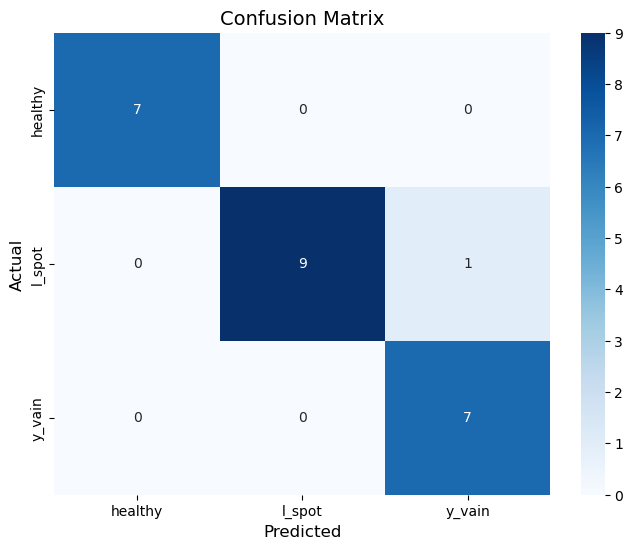

In [25]:
# Define target names
target_names = ['healthy', 'l_spot', 'y_vain']
# Print classification report
print(classification_report(y_test_int, y_pred_test_int, target_names=target_names))

# Generate confusion matrix
cm = confusion_matrix(y_test_int, y_pred_test_int)

# Plot confusion matrix using the blue colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()


In [26]:
# model.save_weights('saved_model/dense121_weight.h5')

In [27]:
# model.save('saved_model/dense121_model.h5')